<a href="https://colab.research.google.com/github/EmmanuelADAM/IntelligenceArtificiellePython/blob/master/summerSchool/NN_4_SentimentsDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
---
# Sentiment Detection

From a collection of movie review data, identified as positive or negative, the task is to train a neural network to classify or estimate reviews.

We use the dataset from [IMDB Dataset of 50K Movie Reviews](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) which you need to download.

This CSV file contains 50,000 movie reviews. These texts consist of important words (tokens), spaces, punctuation marks, and stop words.

The tasks are:
- To clean the texts and build a vocabulary consisting of important and sufficiently used words.
- To select examples used for training and validation.
- To create a good neural network model.

---
If you are using Colab, you need to place the file in your Google Drive.

Then you need to mount the drive directory so that it is accessible by Colab.
Run the following code, a key will be requested. Just follow the link, select your profile to get your key which you will copy into the provided field.

In [ ]:
# Block to execute if you are using Colab
# from google.colab import drive, files

# drive.mount('/content/drive')

---
## Data Preparation

### Loading and Cleaning Data

To process texts, most often you need to:
 - Identify terms (tokens) between spaces,
 - Remove all punctuation,
 - Remove all words that are not composed solely of alphabetic characters,
 - Remove all words recognized as stop words (linking words),
 - Remove all words whose length is less than x characters.

#### Libraries
Data preparation involves being able to access the file system, as well as a natural language processing library (here nltk) and libraries specialized in text processing:

In [47]:
## Imports for files and data processing:
from os import listdir
import pandas as pd
from tqdm import tqdm

## Imports for creating tokens
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

## Imports for managing punctuation
from string import punctuation

## Imports for a specific collection: counter
from collections import Counter

## Imports for neural networks:
# Import the torch library
import torch
# Import the Neural Network class
import torch.nn as nn
# Import the optimizers class
import torch.optim as optim
# Import the DataLoader
from torch.utils.data import DataLoader, TensorDataset

## Classic imports for efficient arrays
import numpy as np
import matplotlib.pyplot as plt

In [45]:
# The following code loads all non-important words (in English)
nltk.download("stopwords")
stop_words = set(stopwords.words('english'))
print(stop_words)

{'ain', "i'd", "she'll", 'at', "she'd", "wasn't", 'him', 'the', "couldn't", 'y', 'isn', 'this', 'wasn', 'more', 'yourself', 'very', 'll', 'hadn', 'here', 'you', 'they', 'over', 'with', 'where', 'above', 'between', 'after', 'had', 'hers', "don't", 'do', 'itself', 't', 'and', 'how', "he'll", 'why', 'an', 'have', "you'd", 'below', 'has', 'so', 'he', 'o', 'shouldn', 'doesn', 'further', 'what', 'm', 'didn', 'we', 'don', "it'd", 'each', 'by', 'me', 'such', 'ma', 'my', 'for', 'am', 'yourselves', 'your', 'through', "we've", "hasn't", 'myself', 'against', 'won', 'out', 'did', 'herself', 'of', 'these', "aren't", 'who', 'while', 'being', 'which', 'both', "isn't", 'his', 'some', "won't", 'nor', "we'd", 'theirs', 'most', 'own', "i'll", 'hasn', 'about', 'does', 'their', 'themselves', 'now', 'will', 'needn', "mustn't", "they're", 'd', "shouldn't", 'no', "that'll", 'not', 'can', 'just', 'on', 'all', "hadn't", 'been', "haven't", 'mightn', 'was', 'up', "you're", 'a', 'as', "weren't", 'only', "we'll", "s

[nltk_data] Error loading stopwords: <urlopen error [WinError 10060]
[nltk_data]     Une tentative de connexion a échoué car le parti
[nltk_data]     connecté n’a pas répondu convenablement au-delà d’une
[nltk_data]     certaine durée ou une connexion établie a échoué car
[nltk_data]     l’hôte de connexion n’a pas répondu>


#### Functions for Reading and Cleaning Text Files

The movie reviews are in the 'review' column of the CSV file.

For each review, we need to retrieve the important words (of sufficient length, without punctuation, without stopwords (a, the, ...).

In [5]:
# Get the text at line num_line of the column and return the cleaned text (without stopwords, words < 2 letters, ...)
def clean_doc(doc: str) -> list:
    """Returns the list of keywords included in the text doc
    that are not part of the stop_words"""
    # Split into tokens by white space
    tokens = wordpunct_tokenize(doc)
    # Remove remaining tokens that are not alphabetic
    tokens = [word.lower() for word in tokens if word.isalpha()]
    # Filter out stop words
    tokens = [w for w in tokens if w not in stop_words]
    # Filter out short tokens
    tokens = [word for word in tokens if len(word) > 2]
    return tokens

In [6]:
# Some types, optional, just for nice code
Series = pd.core.series.Series
DataFrame = pd.core.frame.DataFrame

### Retrieving Texts
Here, the texts to be analyzed are in the 'reviews' column and the outputs in the 'sentiment' column.

In [7]:
# Example directory under Colab
# rep = '/content/drive/My Drive/txt_sentoken'
# Example directory under Windows
rep: str = "./"
filename: str = "IMDB Dataset.csv"
datas: DataFrame = pd.read_csv(rep + filename)
# Retrieve the review column
reviews: Series = datas['review']

In [8]:
tokens: list = clean_doc(reviews[0])
print('The first 10 keywords of ', reviews[0])
print(tokens[:10])

The first 10 keywords of  One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of 

---
### Building the Global Vocabulary

In [9]:
def add_doc_to_vocab(review: str, vocab: Counter):
    """Accumulates the words of the review in the vocab list
    (only one occurrence per word in vocab)"""
    # Clean doc
    tokens = clean_doc(review)
    # Update counts
    vocab.update(tokens)

def build_voc(series: Series, vocab: Counter):
    """Adds to the vocab dictionary the keywords from 90% of the data series"""
    i = 0
    nb = int(series.size)
    # Walk through all files in the folder
    for i in tqdm(range(nb)):
        # Add doc to vocab
        add_doc_to_vocab(series[i], vocab)

In [10]:
# Create a vocabulary (list of keywords associated with their occurrences)
vocab: Counter = Counter()
build_voc(reviews, vocab)
# Display the number of keywords found
print("Number of keywords found in the directories: ", len(vocab))
print("The first 10 keywords of the vocabulary \n and their number of appearances in the examples): \n", end='')
i: int = 0
for (word, count) in vocab.items():
    print(word, ':', count, end=", ")
    i = i + 1
    if i > 10: break
# Display the 10 most used keywords
print("\nThe 10 most used keywords: ", vocab.most_common(10))

100%|██████████| 50000/50000 [00:04<00:00, 10265.04it/s]

Number of keywords found in the directories:  99067
The first 10 keywords of the vocabulary 
 and their number of appearances in the examples): 
one : 53603, reviewers : 493, mentioned : 1079, watching : 9165, episode : 3183, hooked : 284, right : 6529, exactly : 1965, happened : 2054, first : 17583, thing : 9173, 
The 10 most used keywords:  [('movie', 87971), ('film', 79705), ('one', 53603), ('like', 40172), ('good', 29753), ('time', 25110), ('even', 24871), ('would', 24602), ('story', 23119), ('really', 23094)]


In [11]:
# We can, if we want, increase the list of stop words
# One, movie, film do not seem relevant for sentiment analysis
stop_words.add('one')
stop_words.add('movie')
stop_words.add('film')

In [12]:
# Verification by recreating a vocabulary (list of keywords associated with their occurrences)
vocab: Counter = Counter()
build_voc(reviews, vocab)
# Display the number of keywords found
print("Number of keywords found in the directories: ", len(vocab))
print("The first 10 keywords of the vocabulary \n and their number of appearances in the examples): \n", end='')
i: int = 0
for (word, count) in vocab.items():
    print(word, ':', count, end=", ")
    i = i + 1
    if i > 10: break
# Display the 10 most used keywords
print("\nThe 10 most used keywords: ", vocab.most_common(10))

  0%|          | 0/50000 [00:00<?, ?it/s]

100%|██████████| 50000/50000 [00:04<00:00, 10797.01it/s]

Number of keywords found in the directories:  99064
The first 10 keywords of the vocabulary 
 and their number of appearances in the examples): 
reviewers : 493, mentioned : 1079, watching : 9165, episode : 3183, hooked : 284, right : 6529, exactly : 1965, happened : 2054, first : 17583, thing : 9173, struck : 279, 
The 10 most used keywords:  [('like', 40172), ('good', 29753), ('time', 25110), ('even', 24871), ('would', 24602), ('story', 23119), ('really', 23094), ('see', 23029), ('well', 21268), ('much', 19318)]


---
#### Limiting the Vocabulary Size
Each review will be encoded by a vector indicating whether the word from the vocabulary is contained in it.

The size of the vector is therefore the size of the vocabulary.
And therefore, the number of neurons in the input layer will also be as large as this vocabulary.

It is important to find a good balance between a precise but concise vocabulary.

In [13]:
# Keep only keywords appearing at least x times
min_occurrence: int = 50
tokens: list = [token for (token, count) in vocab.items() if count >= min_occurrence]
print('By removing words used less than ', min_occurrence, ' times,', 
      'number of keywords = ', len(tokens))

By removing words used less than  50  times, number of keywords =  10868


In [14]:
def save_list(lines: list, filename: str):
    """Saves the words from the list of comments lines into the file filename"""
    # Convert lines to a single blob of text
    data = '\n'.join(lines)
    # Open file
    file = open(filename, 'w')
    # Write text
    file.write(data)
    # Close file
    file.close()

# Save tokens to a vocabulary file
save_list(tokens, rep + 'vocab.txt')

In [15]:
def load_doc(filename: str) -> str:
    """Returns the text included in the file filename"""
    # Open the file as read-only
    file = open(filename, 'r')
    # Read all text
    text = file.read()
    # Close the file
    file.close()
    return text

---
## Bag of Words Representation

### Convert texts into lists of keywords belonging to the vocabulary

In [16]:
def vocab_in_doc(text: str, vocab: list) -> list:
    """Returns the list of keywords in the text that belong to the vocabulary vocab"""
    # Clean doc
    tokens = clean_doc(text)
    # Filter by vocab
    tokens = [token for token in tokens if token in vocab]
    return ' '.join(tokens)

In [17]:
def process_docs(series: list, vocab: list) -> list:
    """Takes as input a list of texts.
    Returns a list of texts cleaned of words not in the vocabulary"""
    lines = list()

    nb = int(series.size * 0.9)
    # Walk through all files in the folder
    for i in tqdm(range(series.size)):
        line = vocab_in_doc(series[i], vocab)
        lines.append(line)
    return lines

In [18]:
# Load the vocabulary
vocab_filename = 'vocab.txt'
vocab = load_doc(rep + vocab_filename)
vocab = vocab.split()
vocab = set(vocab)

In [19]:
# We only keep a little data to test the functionalities
# We will take everything if the proof of concept is successful
reviews = reviews[:10000]

In [20]:
# Load training and testing reviews
lines_input: list = process_docs(reviews, vocab)
nb_input: int = len(lines_input)

# Summarize what we have
print("Number of examples: ", nb_input)

100%|██████████| 10000/10000 [00:00<00:00, 11208.28it/s]

Number of examples:  10000


In [21]:
print("Input 0")
print("Initial text: \n", reviews[0])
print("Kept text: \n", lines_input[0])

Input 0
Initial text: 
 One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of th

---
### Convert Lists of Words into Frequency of Appearance Vectors
#### Create the Bag of Words for the Training Set

In [22]:
# Create the Vectorizer based on the vocabulary
vectorizer = CountVectorizer()
vectorizer.fit(lines_input)

,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None
,stop_words,None
,token_pattern,'(?u)\\b\\w\\w+\\b'
,ngram_range,"(1, ...)"
,analyzer,'word'


In [23]:
# Create the frequency matrix
def texts_to_matrix_freq(texts):
    # Count occurrences
    count_matrix = vectorizer.transform(texts).toarray()
    # Convert to frequencies (divide by the total number of words per document)
    word_counts = count_matrix.sum(axis=1, keepdims=True)
    # Avoid division by zero
    word_counts[word_counts == 0] = 1
    freq_matrix = count_matrix / word_counts
    return freq_matrix

#### Define Inputs

In [24]:
X_data = texts_to_matrix_freq(lines_input)

In [25]:
print('X_data contains ', X_data.shape[0], ' examples of ', X_data.shape[1], ' values')
print('A value = frequencies of appearance of words in the global vocabulary.')
print(f"Thus, the sum of the values of an input = {np.sum(X_data[0]):.2f}.")

X_data contains  10000  examples of  10867  values
A value = frequencies of appearance of words in the global vocabulary.
Thus, the sum of the values of an input = 1.00.


#### Define Outputs
We decide that positive examples correspond to an output of 1 and negative examples correspond to an output of 0:

In [26]:
# y = list of (1 (rating for positive evaluation) and 0 (ratings for negative evaluation))
sentiments: Series = datas['sentiment']
sentiments_output: Series = sentiments[:nb_input]
yOutput: np.ndarray = np.zeros((nb_input, 1))
for i in range(nb_input): 
    if sentiments_output[i] == 'positive': yOutput[i] = 1

In [27]:
## Definition of tensors
# Convert inputs and outputs to tensors
X_tensor = torch.tensor(X_data, dtype=torch.float32)
y_tensor = torch.tensor(yOutput, dtype=torch.float32)
# Ensure y_tensor has the correct shape
if len(y_tensor.shape) == 1:
    y_tensor = y_tensor.unsqueeze(1)  # (N,) -> (N, 1)
elif len(y_tensor.shape) == 3:
    y_tensor = y_tensor.squeeze()     # (N, 1, 1) -> (N, 1)

#### Test and Validation Sets
Let's keep 90% of the examples for training and 10% for testing...

---
## Neural Network Model for Sentiment Analysis
The network contains as many neurons in the input layer as retained values.

In [28]:
# The number of neurons in the input layer (= number of retained tokens)
n_words = X_data.shape[1]

In [29]:
model = nn.Sequential()

In [30]:
model.add_module('input layer', nn.Linear(n_words, n_words//3, bias=True))
model.add_module('activ_input', nn.ELU())
model.add_module('hidden layer 1', nn.Linear(n_words//3, n_words//27, bias=False))
model.add_module('activ_h1', nn.ELU())
model.add_module('hidden layer 2', nn.Linear(n_words//27, n_words//243, bias=False))
model.add_module('activ_h2', nn.ELU())
model.add_module('output layer', nn.Linear(n_words//243, 1, bias=False))
model.add_module('activ_output', nn.Sigmoid())

# model.compile(loss='hinge', optimizer='adam', metrics=['accuracy'])

In [31]:
## Display the model
print(model)

Sequential(
  (input layer): Linear(in_features=10867, out_features=3622, bias=True)
  (activ_input): ELU(alpha=1.0)
  (hidden layer 1): Linear(in_features=3622, out_features=402, bias=False)
  (activ_h1): ELU(alpha=1.0)
  (hidden layer 2): Linear(in_features=402, out_features=44, bias=False)
  (activ_h2): ELU(alpha=1.0)
  (output layer): Linear(in_features=44, out_features=1, bias=False)
  (activ_output): Sigmoid()
)


In [32]:
#number of weights
total_w = n_words//3*(n_words + 1) + n_words//27*(n_words//3 + 1) + n_words//243*(n_words//27 + 1) + (n_words//243 + 1) 
print(f"total weights for the model={total_w} !!!")


total weights for the model=40838119 !!!


---
## Error Correction
Here, we specify that the error correction algorithm is *'adam'*, and that the calculated error is hinge: $L(y, f(x)) = max(0, 1 - y * f(x))$.

In [33]:
# Use the mean squared error function
criterion = nn.BCEWithLogitsLoss()
# Use the Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

Define Precision

In [34]:
def calculate_accuracy(outputs, targets):
    """Calculate accuracy for binary classification"""
    with torch.no_grad():
        # Convert logits to predictions
        predictions = torch.sigmoid(outputs) > 0.5
        predictions = predictions.float()
        accuracy = (predictions == targets).float().mean()
        return accuracy.item()

---
#### Structuring Inputs and Outputs
Each input can be composed of 10,000 values (if the retained vocabulary contains 10,000 words). There are 50,000 inputs.

Processing all examples to correct the weights once will be memory-intensive.

We decide to correct the weights every 1,000 examples processed (if your machine has little memory, decrease the batch size).

So, each 1000 examples, the weight are corrected with the mean error done when training these examples.

---
#### Training

In [35]:
def train_with_metrics(model, X_data, y_data, epochs=5, batch_size=1000, 
                       validation_split=0.1, steps_per_epoch=10, verbose=True):
    """Trains the model with performance metrics
    Args:
        model: The PyTorch model to train.
        X_data: The input data (features).
        y_data: The output labels (targets).
        epochs: Number of epochs for training.
        batch_size: Batch size for training.
        validation_split: Proportion of data to use for validation.
        steps_per_epoch: Number of batches per epoch.
        verbose: Print info if true."""

    ## Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=validation_split, random_state=42)

    # Create DataLoaders for batch training and validation
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)

    # CPU or GPU configuration (faster!!)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    ## Initialize the loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters())

    # History for plots
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

    # Training
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_accuracy = 0.0
        train_batches = 0

        # Sweep through the training data in batches
        for i, (inputs, targets) in enumerate(train_loader):
            if i >= steps_per_epoch:
                break

            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Metrics
            train_loss += loss.item()
            train_accuracy += calculate_accuracy(outputs, targets)
            train_batches += 1

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_accuracy = 0.0
        val_batches = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                val_accuracy += calculate_accuracy(outputs, targets)
                val_batches += 1

        # Averages
        avg_train_loss = train_loss / train_batches
        avg_val_loss = val_loss / val_batches
        avg_train_accuracy = train_accuracy / train_batches
        avg_val_accuracy = val_accuracy / val_batches

        # Store in history
        history['loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['accuracy'].append(avg_train_accuracy)
        history['val_accuracy'].append(avg_val_accuracy)

        # Display
        if verbose:
            print(f'Epoch [{epoch+1}/{epochs}] - '
                  f'Loss: {avg_train_loss:.4f} - '
                  f'Acc: {avg_train_accuracy:.4f} - '
                  f'Val Loss: {avg_val_loss:.4f} - '
                  f'Val Acc: {avg_val_accuracy:.4f}')

    return history

#### Train the Network

In [36]:
# Training with metrics
history = train_with_metrics(
    model, X_tensor, y_tensor,
    epochs=35,
    batch_size=1000,
    validation_split=0.1,
    steps_per_epoch=10,
    verbose=True
)

Epoch [1/35] - Loss: 0.7029 - Acc: 0.5027 - Val Loss: 0.6915 - Val Acc: 0.5040
Epoch [2/35] - Loss: 0.6919 - Acc: 0.5027 - Val Loss: 0.6921 - Val Acc: 0.5040
Epoch [3/35] - Loss: 0.6801 - Acc: 0.5027 - Val Loss: 0.6482 - Val Acc: 0.5040
Epoch [4/35] - Loss: 0.6111 - Acc: 0.5027 - Val Loss: 0.5967 - Val Acc: 0.5040
Epoch [5/35] - Loss: 0.5548 - Acc: 0.5028 - Val Loss: 0.5760 - Val Acc: 0.5040
Epoch [6/35] - Loss: 0.5328 - Acc: 0.5107 - Val Loss: 0.5679 - Val Acc: 0.5270
Epoch [7/35] - Loss: 0.5216 - Acc: 0.5447 - Val Loss: 0.5670 - Val Acc: 0.5590
Epoch [8/35] - Loss: 0.5156 - Acc: 0.5863 - Val Loss: 0.5688 - Val Acc: 0.5730
Epoch [9/35] - Loss: 0.5128 - Acc: 0.5990 - Val Loss: 0.5683 - Val Acc: 0.6010
Epoch [10/35] - Loss: 0.5113 - Acc: 0.6193 - Val Loss: 0.5722 - Val Acc: 0.6010
Epoch [11/35] - Loss: 0.5107 - Acc: 0.6260 - Val Loss: 0.5709 - Val Acc: 0.6140
Epoch [12/35] - Loss: 0.5104 - Acc: 0.6369 - Val Loss: 0.5744 - Val Acc: 0.6090
Epoch [13/35] - Loss: 0.5098 - Acc: 0.6322 - Val 

---
### Drawing the Evolution of Error

In [39]:
def plot_training_history(history):
    """Plot error and accuracy graphs"""

    epochs = range(1, len(history['loss']) + 1)

    # Create a figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot 1: Evolution of error (loss)
    ax1.plot(epochs, history['loss'], 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    ax1.set_title('Evolution of Error', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Evolution of accuracy
    ax2.plot(epochs, history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_title('Evolution of Accuracy', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1)  # Accuracy between 0 and 1

    plt.tight_layout()
    plt.show()

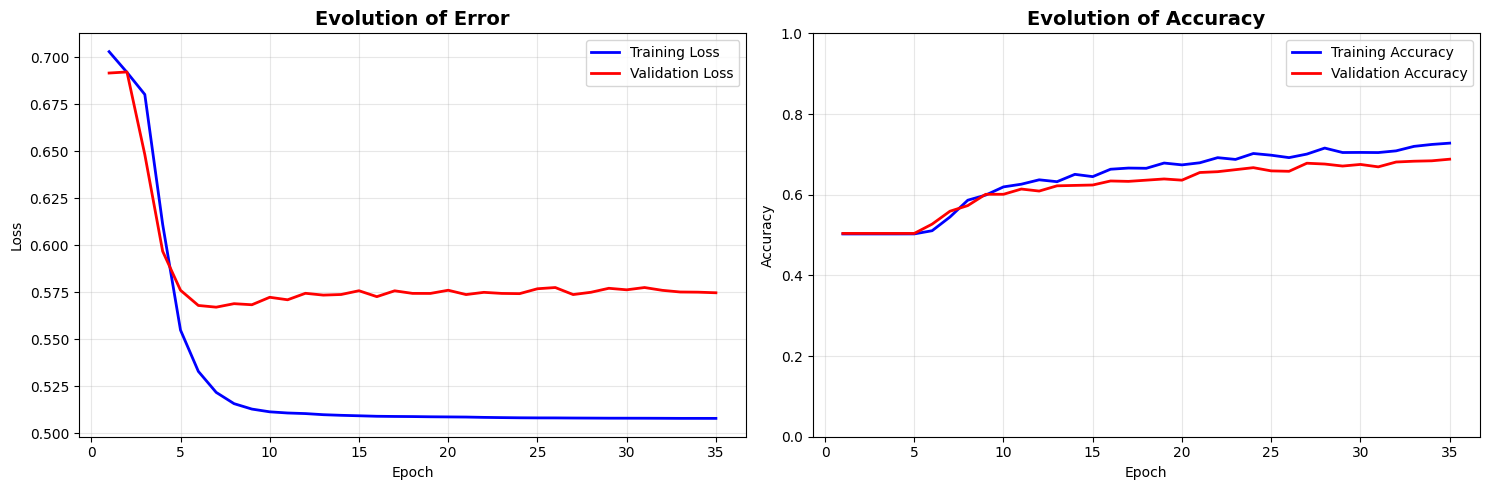


Final Results:
Final Loss: 0.5078
Final Accuracy: 0.7278
Final Validation Loss: 0.5746
Final Validation Accuracy: 0.6880


In [40]:
# Plot the graphs
plot_training_history(history)

# Display the final results
print(f"\nFinal Results:")
print(f"Final Loss: {history['loss'][-1]:.4f}")
print(f"Final Accuracy: {history['accuracy'][-1]:.4f}")
print(f"Final Validation Loss: {history['val_loss'][-1]:.4f}")
print(f"Final Validation Accuracy: {history['val_accuracy'][-1]:.4f}")

---
#### Save the model
We can decide to save the model to reuse it latter directly, without all the training steps...

In [ ]:
#save the network
#def save_model(model, filename='model.pth'):
#    torch.save(model.state_dict(), filename)
#    print(f'Model saved to {filename}')

#save_model(model, filename='model_sentiment.pth')

In [ ]:
## load the model
#def load_model(model, filename='model.pth'):
#    model.load_state_dict(torch.load(filename))
#    model.eval()
#    print(f'Model loaded from {filename}')
#    return model

#load_model(model, filename='model_sentiment.pth')

Model loaded from model_sentiment.pth


Sequential(
  (input layer): Linear(in_features=10867, out_features=3622, bias=True)
  (activ_input): ELU(alpha=1.0)
  (hidden layer 1): Linear(in_features=3622, out_features=402, bias=False)
  (activ_h1): ELU(alpha=1.0)
  (hidden layer 2): Linear(in_features=402, out_features=44, bias=False)
  (activ_h2): ELU(alpha=1.0)
  (output layer): Linear(in_features=44, out_features=1, bias=False)
  (activ_output): Sigmoid()
)

---
## Estimation of New Reviews
All that remains is to use the network to facilitate the classification of future reviews...

In [49]:
def predict_sentiment(review, vocab, model):
    """Classifies the text in the variable 'review' as positive (0) or negative (1)"""

    # Determine the device of the model
    device = next(model.parameters()).device

    # Clean
    tokens = clean_doc(review)
    # Filter by vocab
    tokens = [w for w in tokens if w in vocab]
    # Convert to line
    line = ' '.join(tokens)
    # Create the bag of words with the words used in the line
    encoded = texts_to_matrix_freq([line])

    # Convert the tensor and send it to the correct device
    encoded = torch.tensor(encoded, dtype=torch.float32).to(device)

    # Prediction with model.eval() and torch.no_grad() for inference
    model.eval()
    with torch.no_grad():
        output = model(encoded)
        output = output.cpu().detach().numpy()

    return output[0, 0]  # Return the first value of the prediction

In [50]:
# Test of a review associated with a score of 10/10
text = "I went into watching The White Lotus not really knowing what to expect. I just finished the second season and now know why it's had so many great reviews and won so many awards. What makes this show so good is the acting and the writing. Each character is beautifully written and acted, not a weak link on either season. HBO always puts out great content and this is no different. It's not a show for everyone but I definitely enjoyed it. It's one of the rare anthology shows where both seasons are equally as good. I'm now looking forward to future seasons of The White Lotus and hope they stay as good as these first two."
result = predict_sentiment(text, vocab, model)
print('"', text, '"\n ------> is considered ', 'positive' if result > 0.5 else 'negative')
print(result)
print("=-=-=-=-=-=-=-=-=-=-=-=")
# Test of a review associated with a score of 1/10
text = "I love Minecraft game. I'm a fan of the game. But this movie? OMG! The VFX and visuals, totally green screen. It was like somebody created 3D scenes inside a 3D engine and then they shot the movie on a green screen and then applied the 'Chroma Key' effect. I felt like that way. Forget about plot, I only watched this movie because I wanted to see the game in real world. But all I got was a basic level green screen editing. In fact, the border lines of the chroma key (green screen) were clearly visible on screen. The animations, 3D models, often do not align correctly with the real world human characters. It was awful experience. I felt like they put least effort in making this movie. I love Minecraft game but this movie disappointed me, all because of the low efforts in making it more realistic. I felt like they didn't even tried to hide the visual mistakes in the final product. God bless."
result = predict_sentiment(text, vocab, model)
print('"', text, '"\n ------> is considered ', 'positive' if result > 0.5 else 'negative')
print(result)


text = 'This was a perfect sequel to Denis part one. It accomplished all the main plot points of the book while delivering stellar performances and visuals that most films only dream of having. This film will go down as one of the best in sci-fi/fantasy and it deserves all the laurels it will be gifted. Not in the longest time has a franchise, and a singular movie, captivated me in such a way. This story, these characters, this planet, Dune, lives rent-free in my mind. You would be doing yourself a disservice not seeing this film in IMAX, as the soundscapes created and the soundtrack by Hans Zimmer are so immersive you feel like you are a part of every scene. This movie is a masterpiece in storytelling.'
# Test of a review associated with a score of 10/10
result = predict_sentiment(text, vocab, model)
print('"', text, '"\n ------> is considered ', 'positive' if result > 0.5 else 'negative')
print(result)

" I went into watching The White Lotus not really knowing what to expect. I just finished the second season and now know why it's had so many great reviews and won so many awards. What makes this show so good is the acting and the writing. Each character is beautifully written and acted, not a weak link on either season. HBO always puts out great content and this is no different. It's not a show for everyone but I definitely enjoyed it. It's one of the rare anthology shows where both seasons are equally as good. I'm now looking forward to future seasons of The White Lotus and hope they stay as good as these first two. "
 ------> is considered  positive
1.0
=-=-=-=-=-=-=-=-=-=-=-=
" I love Minecraft game. I'm a fan of the game. But this movie? OMG! The VFX and visuals, totally green screen. It was like somebody created 3D scenes inside a 3D engine and then they shot the movie on a green screen and then applied the 'Chroma Key' effect. I felt like that way. Forget about plot, I only watc

In [51]:
# Test of a review associated with a score of 10/10
text = "I'm happy to present the different parts of AI to you"
result = predict_sentiment(text, vocab, model)
print('"', text, '"\n ------> is considered ', 'positive' if result > 0.5 else 'negative')
print(result)

" I'm happy to present the different parts of AI to you "
 ------> is considered  positive
1.0


In [52]:
# Test of a review associated with a score of 10/10
text = "this movie is very bad."
result = predict_sentiment(text, vocab, model)
print('"', text, '"\n ------> is considered ', 'positive' if result > 0.5 else 'negative')
print(result)

" this movie is very bad. "
 ------> is considered  negative
6.780625e-39
